In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import pandas as pd

In [3]:
#data = pd.read_csv('/content/drive/My Drive/solar-forecasting/data/meteo_galicia.csv', sep=';', parse_dates=['fecha'], decimal=',',
#                 infer_datetime_format=True, low_memory=False, index_col='fecha').sort_index()

### Cargar datos

In [4]:
data = pd.read_csv('./data/meteo_galicia.csv', sep=';', parse_dates=['fecha'], decimal=',',
                 infer_datetime_format=True, low_memory=False, index_col='fecha').sort_index()

In [5]:
data

,estacionid,lat,lon,tamb,hum,pres,prec,rad,vvien,tipodered
fecha,,,,,,,,,,
2019-01-01 00:10:00,20284,42.4044,-8.6730,5.4,0,1022.0,0.0,0.0,0.7,OFICIAL
2019-01-01 00:10:00,20233,42.3554,-7.0086,7.3,0,892.1,0.0,0.0,3.5,OFICIAL
2019-01-01 00:10:00,20218,43.1626,-7.2826,9.2,0,955.0,0.0,0.0,0.0,OFICIAL
2019-01-01 00:10:00,20217,42.7071,-7.0471,8.5,0,882.5,0.0,1.0,6.3,OFICIAL
2019-01-01 00:10:00,20221,43.5407,-7.0830,5.3,0,1027.0,0.0,0.0,2.8,OFICIAL
...,...,...,...,...,...,...,...,...,...,...
2019-06-01 19:40:00,20249,42.2987,-7.5907,25.0,0,909.0,0.0,402.0,2.0,OFICIAL
2019-06-01 19:40:00,20259,42.1630,-7.0896,27.0,0,922.0,0.0,374.0,3.0,OFICIAL
2019-06-01 19:40:00,20255,42.4631,-6.9295,30.0,0,NaN,0.0,378.0,0.0,OFICIAL


### Eliminar columnas innecesarias

In [6]:
data = data.drop(columns=['tipodered', 'hum', 'prec', 'vvien', 'pres'])

In [7]:
len(data)

2510008

In [8]:
data.isnull().sum()

estacionid        0
lat               0
lon               0
tamb           2475
rad           10847
dtype: int64

In [9]:
data = data.dropna()

In [10]:
len(data)

2496903

In [11]:
data.isnull().sum()

estacionid    0
lat           0
lon           0
tamb          0
rad           0
dtype: int64

### Obtener id de las estaciones

In [12]:
estaciones = [s for s in set(data['estacionid'])]

len(estaciones)

142

### Obtener datos de las estaciones

**Las estaciones que no tienen registro de radiación son eliminadas**

In [13]:
%%time
data_by_station = []

for s in estaciones:
    filter_station = data['estacionid'] == s
    data_station = data[filter_station].drop(columns=['estacionid'])
    d = data_station.describe()
    if d.rad['max'] != 0:
        data_by_station.append(data_station)

CPU times: user 3.71 s, sys: 4.87 ms, total: 3.72 s
Wall time: 3.73 s


In [14]:
len(data_by_station)

111

### Ajustar intervalos de tiempo

**Ajuste de 1 hora**

In [15]:
%%time
data_by_station = [s.resample('1H').mean().ffill().bfill() for s in data_by_station]

CPU times: user 491 ms, sys: 207 µs, total: 491 ms
Wall time: 492 ms


### Agregar numero del día y del mes a los datos de cada estación

In [16]:
%%time
for d in data_by_station:
    d['day']=[x.day for x in d.index]
    d['month']=[x.month for x in d.index]
    d['hour']=[x.hour for x in d.index]

CPU times: user 2.46 s, sys: 29.6 ms, total: 2.49 s
Wall time: 2.5 s


In [17]:
data_by_station[0]

,lat,lon,tamb,rad,day,month,hour
fecha,,,,,,,
2019-01-01 01:00:00,43.3634,-8.4419,10.700,0.000000,1,1,1
2019-01-01 02:00:00,43.3634,-8.4419,10.350,0.000000,1,1,2
2019-01-01 03:00:00,43.3634,-8.4419,9.800,0.000000,1,1,3
2019-01-01 04:00:00,43.3634,-8.4419,11.125,0.000000,1,1,4
2019-01-01 05:00:00,43.3634,-8.4419,11.675,0.000000,1,1,5
...,...,...,...,...,...,...,...
2019-06-01 15:00:00,43.3634,-8.4419,22.750,851.000000,1,6,15
2019-06-01 16:00:00,43.3634,-8.4419,22.500,800.500000,1,6,16
2019-06-01 17:00:00,43.3634,-8.4419,24.750,693.750000,1,6,17


### Unir todos los datos de las estaciones

In [18]:
data = pd.concat(data_by_station)

In [19]:
data.shape

(403999, 7)

In [20]:
data

,lat,lon,tamb,rad,day,month,hour
fecha,,,,,,,
2019-01-01 01:00:00,43.3634,-8.4419,10.700000,0.000000,1,1,1
2019-01-01 02:00:00,43.3634,-8.4419,10.350000,0.000000,1,1,2
2019-01-01 03:00:00,43.3634,-8.4419,9.800000,0.000000,1,1,3
2019-01-01 04:00:00,43.3634,-8.4419,11.125000,0.000000,1,1,4
2019-01-01 05:00:00,43.3634,-8.4419,11.675000,0.000000,1,1,5
...,...,...,...,...,...,...,...
2019-06-01 15:00:00,42.5801,-8.8047,24.000000,993.333333,1,6,15
2019-06-01 16:00:00,42.5801,-8.8047,24.500000,925.666667,1,6,16
2019-06-01 17:00:00,42.5801,-8.8047,24.833333,804.666667,1,6,17


### Escalar 

In [21]:
class Scaler:
    def fit(self, data):
        self._min = data.min()
        self._max = data.max()
    
    def normalize(self, data):
        return (data - self._min) / (self._max - self._min)
    
    def denormalize(self, data):
        return data*(self._max-self._min)+self._min

In [22]:
tamb_scaler = Scaler()
tamb_scaler.fit(data['tamb'])
data['tamb'] = tamb_scaler.normalize(data['tamb'])

rad_scaler = Scaler()
rad_scaler.fit(data['rad'])
data['rad'] = rad_scaler.normalize(data['rad'])

data

,lat,lon,tamb,rad,day,month,hour
fecha,,,,,,,
2019-01-01 01:00:00,43.3634,-8.4419,0.513208,0.000000,1,1,1
2019-01-01 02:00:00,43.3634,-8.4419,0.506604,0.000000,1,1,2
2019-01-01 03:00:00,43.3634,-8.4419,0.496226,0.000000,1,1,3
2019-01-01 04:00:00,43.3634,-8.4419,0.521226,0.000000,1,1,4
2019-01-01 05:00:00,43.3634,-8.4419,0.531604,0.000000,1,1,5
...,...,...,...,...,...,...,...
2019-06-01 15:00:00,42.5801,-8.8047,0.764151,0.872493,1,6,15
2019-06-01 16:00:00,42.5801,-8.8047,0.773585,0.813058,1,6,16
2019-06-01 17:00:00,42.5801,-8.8047,0.779874,0.706778,1,6,17


### Preparación de los datos para el entrenamiento de la red

In [23]:
import numpy as np
import tensorflow as tf

# Se fija la semilla para generar valores aleatorios
np.random.seed(1)
tf.random.set_seed(1)

In [24]:
data_target = data['rad'].values
data_input = data.drop(columns=['rad']).values

In [25]:
data_input.shape

(403999, 6)

In [26]:
data_target.shape

(403999,)

#### Neural Nerwork

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import mae

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
%%time
X_train, X_test, y_train, y_test = train_test_split(data_input, data_target, train_size=0.8)

CPU times: user 77.3 ms, sys: 58 µs, total: 77.4 ms
Wall time: 87.9 ms


In [30]:
def rad_mae(x, y):
    X = rad_scaler.denormalize(x)
    Y = rad_scaler.denormalize(y)
    
    return mae(X, Y)

In [31]:
model = Sequential([
    Dense(300, input_dim=X_train.shape[1], activation='sigmoid'),
    Dense(100, activation='sigmoid'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='mae', optimizer='adam', metrics=[rad_mae])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               2100      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 32,301
Trainable params: 32,301
Non-trainable params: 0
_________________________________________________________________


In [32]:
%%time
history = model.fit(X_train, y_train, epochs=10, validation_split=0.3, verbose=2)

Epoch 1/10
7070/7070 - 25s - loss: 0.0658 - rad_mae: 74.8833 - val_loss: 0.0599 - val_rad_mae: 68.2154
Epoch 2/10
7070/7070 - 23s - loss: 0.0466 - rad_mae: 53.0933 - val_loss: 0.0418 - val_rad_mae: 47.5818
Epoch 3/10
7070/7070 - 27s - loss: 0.0419 - rad_mae: 47.6660 - val_loss: 0.0409 - val_rad_mae: 46.5617
Epoch 4/10
7070/7070 - 23s - loss: 0.0399 - rad_mae: 45.4142 - val_loss: 0.0383 - val_rad_mae: 43.6269
Epoch 5/10
7070/7070 - 22s - loss: 0.0387 - rad_mae: 44.0748 - val_loss: 0.0371 - val_rad_mae: 42.2629
Epoch 6/10
7070/7070 - 24s - loss: 0.0380 - rad_mae: 43.2117 - val_loss: 0.0374 - val_rad_mae: 42.6358
Epoch 7/10
7070/7070 - 22s - loss: 0.0373 - rad_mae: 42.4628 - val_loss: 0.0374 - val_rad_mae: 42.5829
Epoch 8/10
7070/7070 - 27s - loss: 0.0366 - rad_mae: 41.7076 - val_loss: 0.0368 - val_rad_mae: 41.8501
Epoch 9/10
7070/7070 - 23s - loss: 0.0362 - rad_mae: 41.2129 - val_loss: 0.0361 - val_rad_mae: 41.1537
Epoch 10/10
7070/7070 - 25s - loss: 0.0357 - rad_mae: 40.6811 - val_loss:

In [33]:
%%time
model.evaluate(X_test, y_test)

2525/2525 [==============================] - 6s 2ms/step - loss: 0.0347 - rad_mae: 39.5107
CPU times: user 11.7 s, sys: 9.77 s, total: 21.5 s
Wall time: 6.51 s


[0.034704241901636124, 39.510704040527344]

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize': (16, 6)})

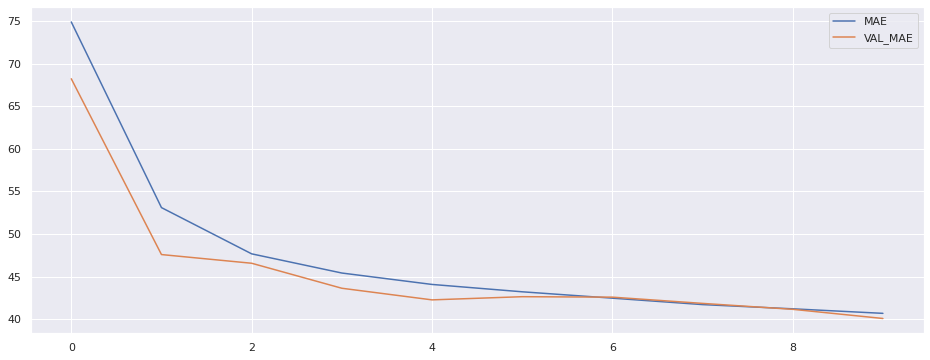

In [35]:
plt.plot(history.history['rad_mae'], label='MAE')
plt.plot(history.history['val_rad_mae'], label='VAL_MAE')
plt.legend()
plt.show()

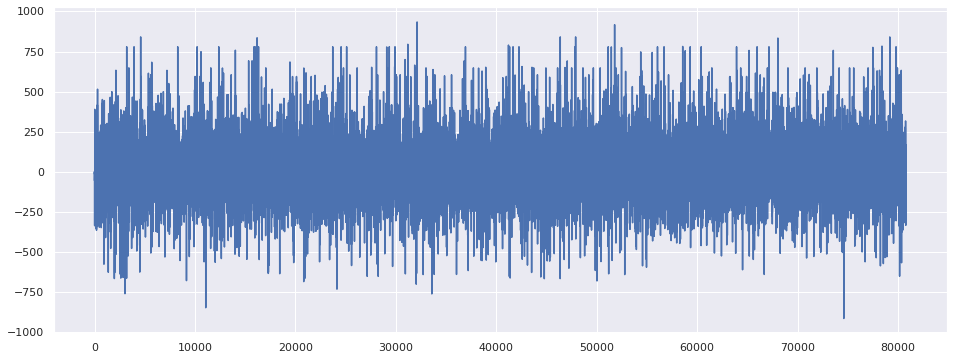

In [36]:
y_predicted = model.predict(X_test)

YP = rad_scaler.denormalize(y_predicted)
YT = rad_scaler.denormalize(y_test)

YT = YT.reshape(YT.shape[0], 1)

error = YT - YP

plt.plot(error)
plt.show()